In [1]:
!pip install -q "git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/CLIP"
!pip install -q "git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/ml-mobileclip"
!pip install -q "git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/lvis-api"
!pip install -q "git+https://github.com/THU-MIG/yoloe.git"

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 96.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 8.4 MB/s eta 0:00:00


In [2]:
!wget -q https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_blt.pt
!pip install -q roboflow supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 45.3 MB/s eta 0:00:00


In [3]:
!pip install jupyter_bbox_widget
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.2 MB/s eta 0:00:00


In [4]:
from huggingface_hub import hf_hub_download

path = hf_hub_download(repo_id="jameslahm/yoloe", filename="yoloe-v8l-seg.pt", local_dir='.')
path = hf_hub_download(repo_id="jameslahm/yoloe", filename="yoloe-v8l-seg-pf.pt", local_dir='.')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


yoloe-v8l-seg.pt:   0%|          | 0.00/107M [00:00<?, ?B/s]

yoloe-v8l-seg-pf.pt:   0%|          | 0.00/103M [00:00<?, ?B/s]

In [5]:
import supervision as sv
from ultralytics import YOLOE
from PIL import Image

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

# Glass Detection


In [20]:
import numpy as np
default_box=[
    {'x': 44, 'y': 74, 'width': 234, 'height': 412, 'label': 'glass'}
]
boxes=widget.bboxes if widget.bboxes else default_box
bboxes=np.array([
    [
        box['x'],
        box['y'],
        box['x']+box['width'],
        box['y']+box['height']
    ] for box in boxes
], dtype=np.float64)
cls=np.array([NAMES.index(box['label']) for box in boxes], dtype=np.int32)

# Test on Glass


0: 640x640 1 object0, 156.6ms
Speed: 4.8ms preprocess, 156.6ms inference, 160.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 glass, 47.4ms
Speed: 2.8ms preprocess, 47.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


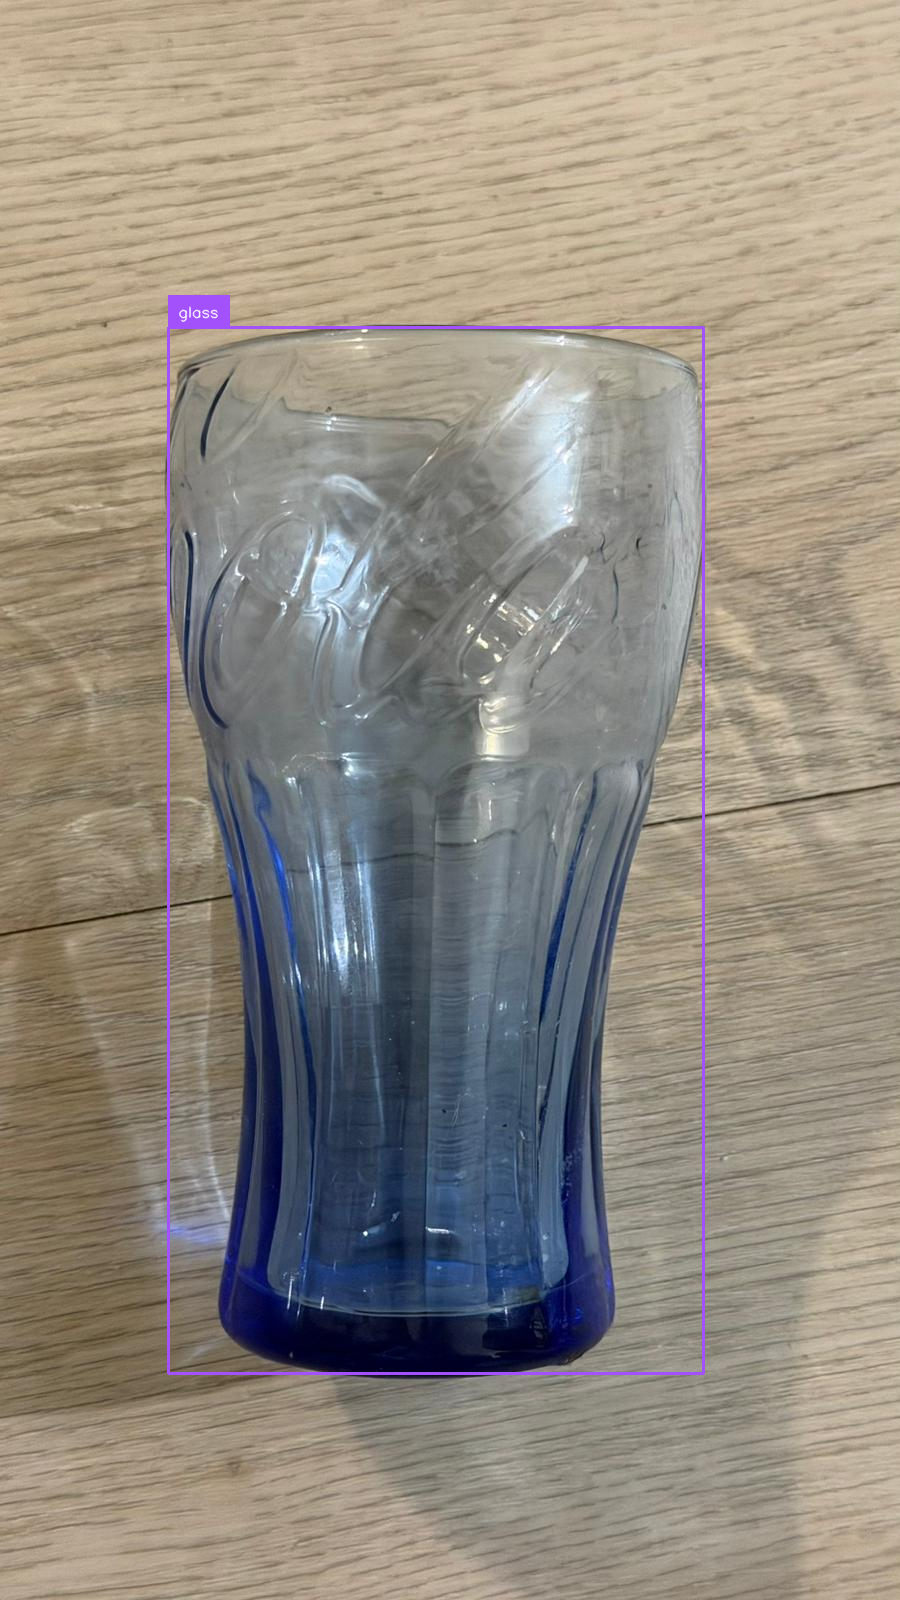

In [21]:
from ultralytics import YOLOE
from ultralytics.models.yolo.yoloe.predict_vp import YOLOEVPSegPredictor

model = YOLOE("yoloe-v8l-seg.pt").cuda()
prompts = dict(bboxes=bboxes, cls=cls)
TARGET_IMAGE_PATH = "/content/test/Glass.jpg"
source_image = Image.open(SOURCE_IMAGE_PATH)
target_image = Image.open(TARGET_IMAGE_PATH)

model.predict(source_image, prompts=prompts, predictor=YOLOEVPSegPredictor, return_vpe=True)
model.set_classes(NAMES, model.predictor.vpe)
model.predictor = None

results = model.predict(target_image)
# results[0].show()

detections = sv.Detections.from_ultralytics(results[0])

annotated_image = target_image.copy()
annotated_image = sv.BoxAnnotator().annotate(scene=annotated_image, detections=detections)
annotated_image = sv.LabelAnnotator().annotate(scene=annotated_image, detections=detections)

annotated_image

# Food Detection


In [29]:
import numpy as np
default_box=[
   {'x': 39, 'y': 70, 'width': 284, 'height': 536, 'label': 'Bio-Waste'}
]
boxes=widget.bboxes if widget.bboxes else default_box
bboxes=np.array([
    [
        box['x'],
        box['y'],
        box['x']+box['width'],
        box['y']+box['height']
    ] for box in boxes
], dtype=np.float64)
cls=np.array([NAMES.index(box['label']) for box in boxes], dtype=np.int32)

# Test on Food



0: 640x640 1 object0, 156.3ms
Speed: 3.4ms preprocess, 156.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Bio-Waste, 48.9ms
Speed: 1.5ms preprocess, 48.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


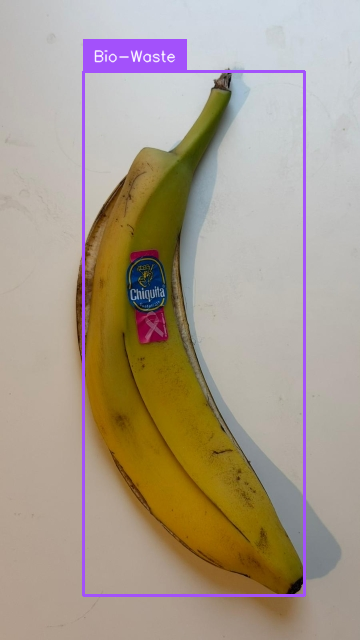

In [30]:
from ultralytics import YOLOE
from ultralytics.models.yolo.yoloe.predict_vp import YOLOEVPSegPredictor

model = YOLOE("yoloe-v8l-seg.pt").cuda()
prompts = dict(bboxes=bboxes, cls=cls)
TARGET_IMAGE_PATH = "/content/test/Bio-waste.jpg"
source_image = Image.open(SOURCE_IMAGE_PATH)
target_image = Image.open(TARGET_IMAGE_PATH)

model.predict(source_image, prompts=prompts, predictor=YOLOEVPSegPredictor, return_vpe=True)
model.set_classes(NAMES, model.predictor.vpe)
model.predictor = None

results = model.predict(target_image)
# results[0].show()

detections = sv.Detections.from_ultralytics(results[0])

annotated_image = target_image.copy()
annotated_image = sv.BoxAnnotator().annotate(scene=annotated_image, detections=detections)
annotated_image = sv.LabelAnnotator().annotate(scene=annotated_image, detections=detections)

annotated_image

# Plastic Detection

In [34]:
import numpy as np
default_box=[
   {'x': 55, 'y': 75, 'width': 243, 'height': 530, 'label': 'Plastic'}
]
boxes=widget.bboxes if widget.bboxes else default_box
bboxes=np.array([
    [
        box['x'],
        box['y'],
        box['x']+box['width'],
        box['y']+box['height']
    ] for box in boxes
], dtype=np.float64)
cls=np.array([NAMES.index(box['label']) for box in boxes], dtype=np.int32)

# Test on Plastic


0: 640x640 (no detections), 162.8ms
Speed: 6.2ms preprocess, 162.8ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Plastic, 47.5ms
Speed: 1.5ms preprocess, 47.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


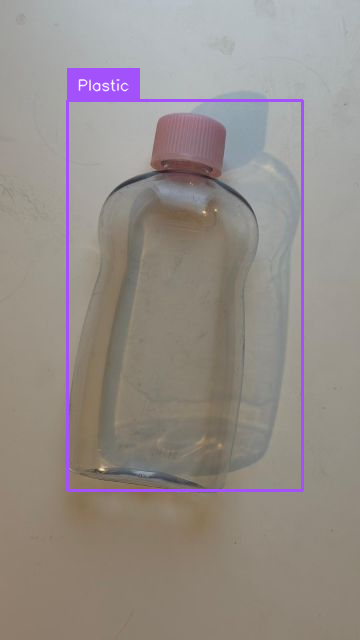

In [35]:
from ultralytics import YOLOE
from ultralytics.models.yolo.yoloe.predict_vp import YOLOEVPSegPredictor

model = YOLOE("yoloe-v8l-seg.pt").cuda()
prompts = dict(bboxes=bboxes, cls=cls)
TARGET_IMAGE_PATH = "/content/test/Plastic_2.jpg"
source_image = Image.open(SOURCE_IMAGE_PATH)
target_image = Image.open(TARGET_IMAGE_PATH)

model.predict(source_image, prompts=prompts, predictor=YOLOEVPSegPredictor, return_vpe=True)
model.set_classes(NAMES, model.predictor.vpe)
model.predictor = None

results = model.predict(target_image)
# results[0].show()

detections = sv.Detections.from_ultralytics(results[0])

annotated_image = target_image.copy()
annotated_image = sv.BoxAnnotator().annotate(scene=annotated_image, detections=detections)
annotated_image = sv.LabelAnnotator().annotate(scene=annotated_image, detections=detections)

annotated_image

# Metal Detection

In [44]:
import numpy as np
default_box=[
   {'x': 9, 'y': 228, 'width': 328, 'height': 220, 'label': 'Metal'}
]
boxes=widget.bboxes if widget.bboxes else default_box
bboxes=np.array([
    [
        box['x'],
        box['y'],
        box['x']+box['width'],
        box['y']+box['height']
    ] for box in boxes
], dtype=np.float64)
cls=np.array([NAMES.index(box['label']) for box in boxes], dtype=np.int32)

# Test on Metal


0: 640x640 1 object0, 156.0ms
Speed: 2.6ms preprocess, 156.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Metal, 49.8ms
Speed: 1.5ms preprocess, 49.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


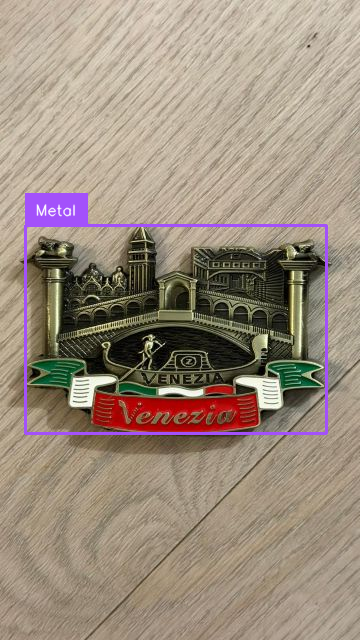

In [47]:
from ultralytics import YOLOE
from ultralytics.models.yolo.yoloe.predict_vp import YOLOEVPSegPredictor

model = YOLOE("yoloe-v8l-seg.pt").cuda()
prompts = dict(bboxes=bboxes, cls=cls)
TARGET_IMAGE_PATH = "/content/test/Metal_1.jpg"
source_image = Image.open(SOURCE_IMAGE_PATH)
target_image = Image.open(TARGET_IMAGE_PATH)

model.predict(source_image, prompts=prompts, predictor=YOLOEVPSegPredictor, return_vpe=True)
model.set_classes(NAMES, model.predictor.vpe)
model.predictor = None

results = model.predict(target_image)
# results[0].show()

detections = sv.Detections.from_ultralytics(results[0])

annotated_image = target_image.copy()
annotated_image = sv.BoxAnnotator().annotate(scene=annotated_image, detections=detections)
annotated_image = sv.LabelAnnotator().annotate(scene=annotated_image, detections=detections)

annotated_image


0: 640x640 1 object0, 142.2ms
Speed: 3.4ms preprocess, 142.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Metal, 59.5ms
Speed: 1.4ms preprocess, 59.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


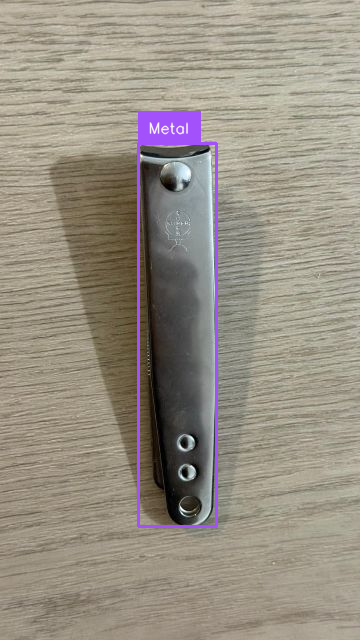

In [56]:
from ultralytics import YOLOE
from ultralytics.models.yolo.yoloe.predict_vp import YOLOEVPSegPredictor
import numpy as np
default_box=[
 {'x': 118, 'y': 140, 'width': 128, 'height': 398, 'label': 'Metal'}
]
boxes=widget.bboxes if widget.bboxes else default_box
bboxes=np.array([
    [
        box['x'],
        box['y'],
        box['x']+box['width'],
        box['y']+box['height']
    ] for box in boxes
], dtype=np.float64)
cls=np.array([NAMES.index(box['label']) for box in boxes], dtype=np.int32)

model = YOLOE("yoloe-v8l-seg.pt").cuda()
prompts = dict(bboxes=bboxes, cls=cls)
TARGET_IMAGE_PATH = "/content/test/Metal_2.jpg"
source_image = Image.open( "/content/test/Metal_2.jpg")
target_image = Image.open(TARGET_IMAGE_PATH)

model.predict(source_image, prompts=prompts, predictor=YOLOEVPSegPredictor, return_vpe=True)
model.set_classes(NAMES, model.predictor.vpe)
model.predictor = None

results = model.predict(target_image)
# results[0].show()

detections = sv.Detections.from_ultralytics(results[0])

annotated_image = target_image.copy()
annotated_image = sv.BoxAnnotator().annotate(scene=annotated_image, detections=detections)
annotated_image = sv.LabelAnnotator().annotate(scene=annotated_image, detections=detections)

annotated_image